In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch


In [2]:
def calc_weight(x, alpha=-0.2):
    return torch.exp(alpha * torch.abs(x))

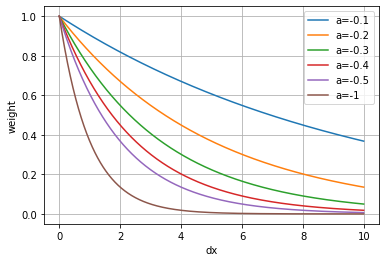

In [3]:
# Visualizing different weights
alpha = [-0.1, -0.2, -0.3, -0.4, -0.5, -1]

N = lambda x, a: np.exp(a*x)
x = np.arange(0, 10, 0.01)

for i in range(len(alpha)):
    plt.plot(x, N(x, alpha[i]), label="a={}".format(alpha[i]))
plt.xlabel('dx')
plt.ylabel('weight')
plt.legend()
plt.grid()

In [4]:
def calc_normal(xi, x0, x1, x2, x3):
    x_n = torch.stack([x0, x1, x2, x3])
    delta_x = x_n - xi
    dist = torch.norm(delta_x, dim=1)
    weights = calc_weight(dist)
    
    normals = []
    for i in range(len(delta_x)):
        if i < len(delta_x) - 1:
            N_i = torch.cross(weights[i] *  delta_x[i], weights[i+1] * delta_x[i+1])
        else:
            N_i = torch.cross(weights[i] * delta_x[i], weights[0] * delta_x[0])
        normals.append(N_i)

    normals = torch.stack(normals)
    N = 1/len(normals) * torch.sum(normals, dim=0)
    N /= torch.norm(N)
    return N    

In [5]:
# Test 1: normal calculation
xi = torch.tensor([0, 0, 0], dtype=torch.float)
X = [[1, 0, 0],
     [0, 1, 0],
     [-1, 0, 0],
     [0, -1, 0]]
X = torch.tensor(X, dtype=float)

# ground truth normal
N_gt = torch.tensor([0, 0, 1], dtype=float)

N_hat = calc_normal(xi, X[0], X[1], X[2], X[3])

delta_N = N_gt - N_hat
print("calculated normal: ", N_hat)
print("diff: ", delta_N)

calculated normal:  tensor([0., 0., 1.], dtype=torch.float64)
diff:  tensor([0., 0., 0.], dtype=torch.float64)


In [6]:
# Test 2: normal calculation
xi = torch.tensor([1, -2, 0], dtype=torch.float)
X = [[3, 1, 4],
     [0, -1, 2],
     [-1, -5, -4],
     [2, -3, -2]]

X = torch.tensor(X, dtype=float)

# ground truth normal
N_gt = torch.tensor([0.2074, -0.8296,  0.5185], dtype=float)

N_hat = calc_normal(xi, X[0], X[1], X[2], X[3])

delta_N = N_gt - N_hat
print("calculated normal: ", N_hat)
print("diff: ", delta_N)

calculated normal:  tensor([ 0.2074, -0.8296,  0.5185], dtype=torch.float64)
diff:  tensor([ 9.6611e-06, -3.8644e-05,  2.4153e-05], dtype=torch.float64)


In [7]:
import torch.nn.functional as F

def calc_normal_img(img):
    """
    img is cylindrical projection of a lidar frame, having at least three x, y, z channels.
    image channels are torch ordered, e.g. := [N, C, H, W]
    we also assumes that the x,y,z coordinate are the first 3 channels, also N should be eq. 1
    """
    h, w  = img.shape[2:]
    N  = torch.zeros((3, h, w))
    
    im_padded = F.pad(img[:, 0:3, :, :], (1, 1, 1, 1), mode='replicate')
    # we do not need the batch dim.
    im_padded = im_padded[0]
    h, w  = im_padded.shape[1:]
    for i in range(1, h-1):
        for j in range(1, w-1):
            xi = im_padded[0:3, i ,j]
            x0, x1, x2, x3 = im_padded[0:3, i-1 ,j], im_padded[0:3, i ,j-1], im_padded[0:3, i+1 ,j], im_padded[0:3, i ,j+1]
            N[:, i-1, j-1] = calc_normal(xi, x0, x1, x2, x3)
    return N

In [8]:
import matplotlib
from matplotlib import pyplot as plt

img = torch.rand((1, 3, 10, 10))
N = calc_normal_img(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


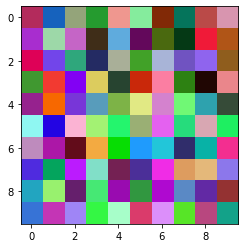

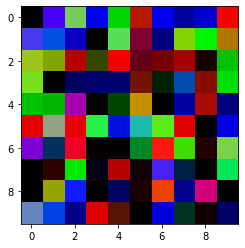

In [9]:
img = img[0, :, :, :]

# plot image
plt.figure()
plt.imshow(img.permute(1, 2, 0))

# plot normals
plt.figure()
plt.imshow(N.permute(1, 2, 0))


def project